# DataCamp Certification Case Study

### Project Brief

Congratulations, you have just landed your first job as a data scientist at Snow Cone Games! Snow Cone Games are a digital retailer for video games. For your first assignment, you will be working with the product manager to find new ways to categorize games on their homepage. 

She has recently learned that only 23% of buyers search for games using the genre filter (e.g., action, sports, etc). 71% of buyers use advanced filters to find the types of games that appeal to them. She hopes that creative new categories based on different game attributes can help players find what they are looking for faster.

You have a dataset containing the Snow Cone Games’ library of over 40,000 video games. The product manager would like to see if you can group the data into categories that make sense. She has also told you that she wants to avoid more than five categories if possible, as any more would be difficult to fit into the platform homepage. 

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the product manager in a 10 minute presentation. The product manager has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/video_games.csv"`


# Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.parser import parse
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from tqdm.notebook import tqdm

# !pip install umap-learn
# import umap

# Load Data

In [ ]:
video_games_orig_df = pd.read_csv('data/video_games.csv')
print('Number of video games:', len(video_games_orig_df))
video_games_orig_df.head()

Number of video games: 40833


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
0,DOOM,"May 12, 2016",id Software,54.0,$19.99,92%,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,$29.99,49%,836608.0,True,True
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,$39.99,71%,7030.0,True,False
3,DayZ,"Dec 13, 2018",Bohemia Interactive,NaN,$44.99,61%,167115.0,True,False
4,EVE Online,"May 6, 2003",CCP,NaN,Free,74%,11481.0,True,False


In [ ]:
for col in video_games_orig_df.columns:
    if video_games_orig_df[col].dtype == 'object':
        print(f'{col}: {len(video_games_orig_df[col][~video_games_orig_df[col].isna()].unique())} unique values out of {len(video_games_orig_df[~video_games_orig_df[col].isnull()])}')
print('\n------- Null data -------')
print(video_games_orig_df.isnull().sum())
print('\n------- Data types -------')
print(video_games_orig_df.dtypes)

name: 40749 unique values out of 40817
release_date: 4107 unique values out of 37654
developer: 17420 unique values out of 40490
original_price: 681 unique values out of 35522
percent_positive: 100 unique values out of 17363
multiplayer: 2 unique values out of 40313

------- Null data -------
name                   16
release_date         3179
developer             343
achievements        28639
original_price       5311
percent_positive    23470
num_reviews         23470
multiplayer           520
mature                  0
dtype: int64

------- Data types -------
name                 object
release_date         object
developer            object
achievements        float64
original_price       object
percent_positive     object
num_reviews         float64
multiplayer          object
mature                 bool
dtype: object


## Data Cleaning

There are some video games with no `name`, let's look at them

In [ ]:
video_games_orig_df[video_games_orig_df['name'].isna()]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
704,NaN,NaN,NaN,NaN,$29.99,NaN,NaN,NaN,False
4847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
23099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Clearly they're unintuitive, let's remove them

In [ ]:
video_games_orig_df.dropna(subset=['name'], inplace=True)
print(len(video_games_orig_df))
video_games_orig_df['name'].isna().sum()

40817


0

`release_date` is not in the datetime format, let's change it

In [ ]:
def format_time(x):
    """
    Convert single time record to datetime object
    """
    if pd.isna(x):
        return np.nan
    try:
        x = parse(x)
    except:
        return np.nan
    return x
if video_games_orig_df['release_date'].dtypes != '<M8[ns]':
    video_games_orig_df['release_date'] = video_games_orig_df['release_date'].apply(format_time)
assert video_games_orig_df['release_date'].dtypes == '<M8[ns]'
print(video_games_orig_df['release_date'].head())
video_games_orig_df['release_date'].isna().sum()

0   2016-05-12
1   2017-12-21
2   2018-04-24
3   2018-12-13
4   2003-05-06
Name: release_date, dtype: datetime64[ns]


4107

There is about 1000 data points that we can't parse with `dateutil.parser.parse`

Clean `developer`

In [ ]:
video_games_orig_df[video_games_orig_df['developer'].isna()]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
146,Steam Controller,2015-11-10,NaN,NaN,$49.99,73%,7942.0,NaN,False
1101,Spelunky,2013-08-08,NaN,20.0,$14.99,90%,8305.0,False,False
1854,Artemis Spaceship Bridge Simulator,2013-09-16,NaN,NaN,$6.99,88%,244.0,True,False
2517,Startopia,2001-06-19,NaN,NaN,$6.99,89%,495.0,False,False
2712,Rayman® Legends,2013-09-03,NaN,NaN,$29.99,91%,2890.0,False,False
...,...,...,...,...,...,...,...,...,...
40235,Valve Index Headset + Controllers,NaT,NaN,NaN,$749.00,NaN,NaN,NaN,False
40238,Valve Index VR Kit,NaT,NaN,NaN,$999.00,NaN,NaN,NaN,False
40248,HTC Vive,2016-04-05,NaN,NaN,$499.00,NaN,NaN,NaN,False
40266,Juventus VR - Become Juve's new signing!,2018-04-20,NaN,NaN,$1.99,NaN,NaN,False,False


There are some games with no developer, having no reviews, no release_date, we should remove those as well

In [ ]:
video_games_orig_df[video_games_orig_df['developer'].isna() & video_games_orig_df['num_reviews'].isna() & video_games_orig_df['release_date'].isna()]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
5157,Ghost In The Shell: Stand Alone Complex 2nd Gig,NaT,NaN,NaN,NaN,NaN,NaN,False,False
6178,Ghost In The Shell: Stand Alone Complex Season 1,NaT,NaN,NaN,NaN,NaN,NaN,False,False
10140,Gintama Season 4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12134,Kemono Friends Season 1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12178,New Game Season 1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12179,Showa Genroku Rakugo Shinju Season 1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12194,Con Man Season 1,NaT,NaN,NaN,NaN,NaN,NaN,False,False
12611,Forge of Gods: Ultimate Titan Bundle,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12793,Digital Sound Factory: Session Drummer 3 Expan...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
12870,Mob Psycho 100 Season 1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False


Clearly they're unintuitive, let's remove them

In [ ]:
video_games_orig_df.drop(video_games_orig_df[video_games_orig_df['developer'].isna() & video_games_orig_df['num_reviews'].isna() & video_games_orig_df['release_date'].isna()].index, 
                        inplace=True)
video_games_orig_df.isna().sum()

name                    0
release_date         4060
developer             280
achievements        28576
original_price       5253
percent_positive    23407
num_reviews         23407
multiplayer           490
mature                  0
dtype: int64

Convert `original_price` to numeric format

In [ ]:
def format_price(x):
    """
    Format price from str to numeric
    """
    if pd.isna(x):
        return np.nan
    
    x = x.lower()
    # demo should be free
    if ('demo' in x) or ('free' in x):
        return 0
    x = x.replace('$', '')
    try:
        x = float(x)
    except: 
        x = np.nan
    return x

In [ ]:
if video_games_orig_df['original_price'].dtypes != float:
    video_games_orig_df['original_price'] = video_games_orig_df['original_price'].apply(lambda x: format_price(x))
video_games_orig_df['original_price'].isna().sum()

5298

We couldn't parse about 50 data points, which is ok given our data size. We assume `original_price` to be 0 if it's `NaN`

In [ ]:
video_games_orig_df['original_price'].fillna(0, inplace=True)
video_games_orig_df['original_price'].isna().sum()

0

Convert `multiplayer` to {1: True, 0: False}

In [ ]:
def bool_to_int(x):
    """
    Convert boolean to int while preserving np.nan
    """
    if pd.isna(x):
        return x

    return 1 if x else 0
video_games_orig_df['multiplayer'] = video_games_orig_df['multiplayer'].apply(bool_to_int)
print(video_games_orig_df['multiplayer'].dtypes)
video_games_orig_df['multiplayer'].head()

float64


0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: multiplayer, dtype: float64

In [ ]:
video_games_orig_df['achievements'].isna().sum() / len(video_games_orig_df['achievements']) 

0.7009075300466029

Games with `achievements` = NaN means that it does not have any achivements related. One can investigate further to see if this assumption is true or how the data collection process might not be consistent, as it doesn't quite make sense for 70% of the game to not have achivements at all knowing most games nowadays all have some sort of achivements

In [ ]:
video_games_orig_df['achievements'].fillna(0, inplace=True)

In [ ]:
video_games_orig_df.isna().sum()

name                    0
release_date         4060
developer             280
achievements            0
original_price          0
percent_positive    23407
num_reviews         23407
multiplayer           490
mature                  0
dtype: int64

Convert `percent_positive` to numeric

In [ ]:
video_games_orig_df['percent_positive'] = video_games_orig_df['percent_positive'].str.replace('%', '').astype(float) / 100

In [ ]:
print('\n------- Null data -------')
print(video_games_orig_df.isna().sum())
print('\n------- Data types -------')
print(video_games_orig_df.dtypes)


------- Null data -------
name                    0
release_date         4060
developer             280
achievements            0
original_price          0
percent_positive    23407
num_reviews         23407
multiplayer           490
mature                  0
dtype: int64

------- Data types -------
name                        object
release_date        datetime64[ns]
developer                   object
achievements               float64
original_price             float64
percent_positive           float64
num_reviews                float64
multiplayer                float64
mature                        bool
dtype: object


If `num_reviews` is NaN, most likely it's 0 

In [ ]:
video_games_orig_df['num_reviews'].fillna(0, inplace=True)
video_games_orig_df['num_reviews'].isna().sum()

0

In [ ]:
print(len(video_games_orig_df))
print('\n------- Null data -------')
print(video_games_orig_df.isna().sum())

40770

------- Null data -------
name                    0
release_date         4060
developer             280
achievements            0
original_price          0
percent_positive    23407
num_reviews             0
multiplayer           490
mature                  0
dtype: int64


Convert `mature` to int {1: True, 0: False}

In [ ]:
video_games_orig_df['mature'] = video_games_orig_df['mature'].apply(bool_to_int)

# EDA

## Generate features & Further Cleaning

Let's look at `original_price`

<AxesSubplot:xlabel='original_price'>

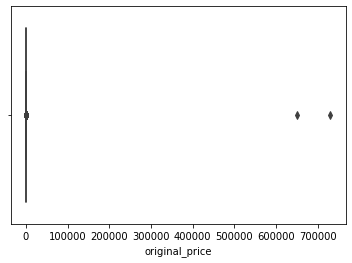

In [ ]:
sns.boxplot(video_games_orig_df['original_price'])

We don't have to remove all the outliers as we'll scale our features using scalers robust against outliers later

In [ ]:
pricey_games = video_games_orig_df[video_games_orig_df['original_price'] > 600000]
pricey_games

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
18639,Slime-san: Superslime Edition,2017-04-07,Fabraz,85.0,650560.0,0.92,27.0,1.0,0
37635,Railgunners,2019-07-07,Expresso Studios,0.0,730640.0,NaN,0.0,0.0,0


Railgunners clearly looks like a scam as it has no reviews and have extremely high price, let's remove it

In [ ]:
video_games_orig_df.drop(video_games_orig_df[video_games_orig_df['name'] == 'Railgunners'].index, inplace=True)
assert len(video_games_orig_df[video_games_orig_df['name'] == 'Railgunners']) == 0

Text(0.5, 0, 'Price')

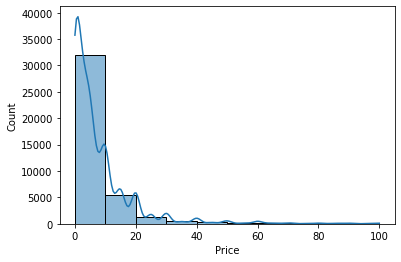

In [ ]:
df = video_games_orig_df['original_price']
ax = sns.histplot(df[df < 100], bins=10, kde=True)
ax.set_xlabel('Price')

The spread of our original_price is still somewhat skewed to the right, with a huge concentration in 0. This suggests that we might want to separate our categories by paid or free

`free` = 1 if price = 0, otherwise 1

In [ ]:
video_games_orig_df['free'] = (video_games_orig_df['original_price'] == 0).apply(bool_to_int)
video_games_orig_df.head()

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature,free
0,DOOM,2016-05-12,id Software,54.0,19.99,0.92,42550.0,1.0,0,0
1,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37.0,29.99,0.49,836608.0,1.0,1,0
2,BATTLETECH,2018-04-24,Harebrained Schemes,128.0,39.99,0.71,7030.0,1.0,0,0
3,DayZ,2018-12-13,Bohemia Interactive,0.0,44.99,0.61,167115.0,1.0,0,0
4,EVE Online,2003-05-06,CCP,0.0,0.00,0.74,11481.0,1.0,0,1


`has_reviews` means that `num_reviews` is not 0

In [ ]:
video_games_orig_df['has_reviews'] = (~video_games_orig_df['num_reviews'].isna()).apply(bool_to_int)
video_games_orig_df.head()

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature,free,has_reviews
0,DOOM,2016-05-12,id Software,54.0,19.99,0.92,42550.0,1.0,0,0,1
1,PLAYERUNKNOWN'S BATTLEGROUNDS,2017-12-21,PUBG Corporation,37.0,29.99,0.49,836608.0,1.0,1,0,1
2,BATTLETECH,2018-04-24,Harebrained Schemes,128.0,39.99,0.71,7030.0,1.0,0,0,1
3,DayZ,2018-12-13,Bohemia Interactive,0.0,44.99,0.61,167115.0,1.0,0,0,1
4,EVE Online,2003-05-06,CCP,0.0,0.00,0.74,11481.0,1.0,0,1,1


To convert `release_date` into numeric for later clustering purpose, we would set the earliest date as 0, and any other date as n, calulated as first_date + n =  current_date

In [ ]:
earliest = video_games_orig_df['release_date'].min()
print(earliest)
video_games_orig_df['release_date_numeric'] = (video_games_orig_df['release_date'] - earliest).dt.days

1981-04-22 00:00:00


<AxesSubplot:xlabel='release_date', ylabel='percent_positive'>

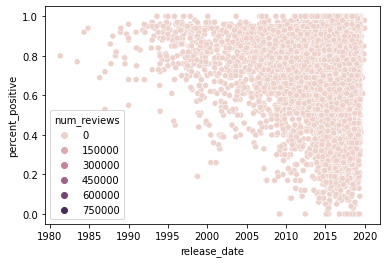

In [ ]:
sns.scatterplot(x='release_date', y='percent_positive', hue='num_reviews', data=video_games_orig_df)

We see the huge cluster in the upper right corner, suggesting a new category "new and popular" 

Let's look at `percent_positive` 

In [ ]:
print(video_games_orig_df['percent_positive'].describe())

count    17363.000000
mean         0.747094
std          0.185751
min          0.000000
25%          0.640000
50%          0.790000
75%          0.890000
max          1.000000
Name: percent_positive, dtype: float64


The average rating is about 74.7%, we might want to impute it with avg. We'll perform an analysis later to see the optimum imputing amount

In [ ]:
print(video_games_orig_df['num_reviews'].describe())

count     40769.000000
mean        554.780936
std        7563.132167
min           0.000000
25%           0.000000
50%           0.000000
75%          42.000000
max      836608.000000
Name: num_reviews, dtype: float64


The spread is huge for `num_reviews`. Thus we would scale our features using scalers that are robust against outliers later

Most popular games are developed by only a few main developers, let's see if that is true in our dataset

In [ ]:
video_games_orig_df.groupby('developer').count().iloc[0, :].sort_values(ascending=False)

name                    3
release_date            3
achievements            3
original_price          3
num_reviews             3
multiplayer             3
mature                  3
free                    3
has_reviews             3
release_date_numeric    3
percent_positive        2
Name: #workshop, dtype: int64

No this assumption is not true, we shouldn't focus our analysis only on the big companies

# Cluster Analysis

## Helper Functions

In [ ]:
def get_clusters(x, n_clusters=4, *, cluster_method='kmean', scaled=True, return_features=True, return_inertia=True):
    """
    Given np.array features, return the cluster labels of each record in np.ndarray 
    Params:
        scaled: whether to scale the input features
        n_clusters: number of clusters
        cluster_method: method to clustering
        return_features: whether to return the scaled/unscaled features
        return_inertia: whether to return inertia for k-mean
    """
    out = {}
    if scaled:
        x = QuantileTransformer(output_distribution="normal").fit_transform(x)
    
    if cluster_method == 'kmean':
        model = KMeans(n_clusters=n_clusters)
    elif cluster_method == 'spectral':
        model = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', n_jobs=-1)
    elif cluster_method == 'dbscan':
        model = DBSCAN(eps=3, min_samples=2)
    model.fit(x)
    
    out['labels_'] = model.labels_
    if return_features:
        out['features_'] = x
    if cluster_method == 'kmean' and return_inertia:
        out['inertia_'] = model.inertia_
    return out

In [ ]:
def create_cluster_proj_df(x, n_clusters=4, *, cluster_method='kmean', projection_method = 'pca', scaled=True):
    """
    Given np.array features, return the clusters and the projected features dataframe
    
    Params:
        n_clusters: number of clusters
        cluster_method: method to clustering
        scaled: whether to scale the input features
    """
    cluster_dict = get_clusters(x, n_clusters=n_clusters, cluster_method=cluster_method, return_features=True)
    labels_, features_ = cluster_dict['labels_'], cluster_dict['features_']
    
    n_components = 2
    if projection_method == 'pca':
        pca = PCA(n_components=n_components)
        proj_features = pca.fit_transform(features_)
    elif projection_method == 'tsne':
        tsne = TSNE(n_components=2, learning_rate='auto', init='random')
        proj_features = tsne.fit_transform(features_)
    elif projection_method == 'umap':
        reducer = umap.UMAP()
        proj_features = reducer.fit_transform(features_)
        
    clusters_df = pd.DataFrame(proj_features, columns=['comp_' + str(i) for i in range(n_components)])
    clusters_df['cluster'] = labels_
    return clusters_df

In [ ]:
def visualize_inertia(arr, from_=2, to_=11):
    """
    Visualize inertia of the clusers using lineplot
    
    Params:
        arr: np.ndarray 
        from_: from cluster number
        to_: to cluster number
    """
    n_clusters_arr = np.arange(from_, to_)
    inertias = []
    for n_clusters in n_clusters_arr:
        cluster_dict = get_clusters(arr, n_clusters=n_clusters)
        inertia = cluster_dict['inertia_']
        print(f'{n_clusters} clusters: inertia={inertia}')
        inertias.append(inertia)

    ax = sns.lineplot(x=n_clusters_arr, y=inertias)
    ax.set_xlabel('Number of Clusters')
    ax.set_ylabel('Inertia')

## Constants

In [ ]:
table_orig_df = video_games_orig_df.copy()
# Select numeric columns
table_orig_df = table_orig_df[['achievements', 'original_price', 'percent_positive', 'num_reviews', 'multiplayer', 'mature', 'free', 'release_date_numeric']]
print(len(table_orig_df))
table_orig_df.isna().sum()

40769


achievements                0
original_price              0
percent_positive        23406
num_reviews                 0
multiplayer               490
mature                      0
free                        0
release_date_numeric     4060
dtype: int64

Let's drop all NaN features of table_orig_df besides `percent_positive`

In [ ]:
table_orig_df = table_orig_df.dropna(subset=['release_date_numeric', 'multiplayer'])
print(table_orig_df.isna().sum())
print()
print(len(table_orig_df))

achievements                0
original_price              0
percent_positive        19145
num_reviews                 0
multiplayer                 0
mature                      0
free                        0
release_date_numeric        0
dtype: int64

36254


## K-Means

K-Means is used here as our data is of the magnitude of 10,000, which is not trivial for other clustering algorithms like Spectral, Agglomarative, etc. Refer to this [link](https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html) for benchmarks of different cluster algorithm's performance.

To combat outliers and skewness of our data discussed in our EDA, we scale our data using QuantileTransformer before runnning the K-Means algorithm. QuantileTransformer will also automatically collapse any outlier by setting them to the a priori defined range boundaries (0 and 1). This can result in saturation artifacts for extreme values. Refer to this [link](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py) for more details

## PCA
We pick PCA as it orthogonalizes the feature space and assign variance explained to each features. We simply pick the first two most informative feature to visualize our clusters.
Another main reason that we use K-Means is due to the sheer size of our dataset discussed earlier, other algorithms like t-SNE and UMAP is infeasible given our compute and data size. For a more robust description, look at this [link](https://umap-learn.readthedocs.io/en/latest/benchmarking.html)

### Effect of imputing `percent_positive`

In [ ]:
table_orig_df['percent_positive'].isna().sum()

19145

We see almost half of our data doesn't have reviews, thus no `percent_positive`. To minimize imputing bias, we'll investigate the effect of imputing it with different values

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

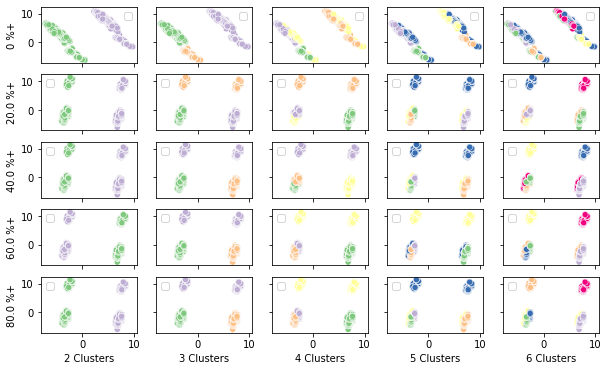

In [ ]:
df = table_orig_df.copy()

percent_p_arr = [0, 0.2, 0.4, 0.6, 0.8]
n_clusters_arr = np.arange(2, 7)
fig, ax = plt.subplots(nrows=len(percent_p_arr), ncols=len(n_clusters_arr), figsize=(10, 6), sharex=True, sharey=True)
for i, percent_p in tqdm(enumerate(percent_p_arr), total=len(percent_p_arr)):
    for j, n_clusters in tqdm(enumerate(n_clusters_arr), total=len(n_clusters_arr), leave=False):
        temp_df = df.copy()
        temp_df['percent_positive'].fillna(percent_p, inplace=True)
        clusters_df = create_cluster_proj_df(temp_df.values, n_clusters=n_clusters, scaled=True)  
        sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', ax=ax[i, j], palette='Accent')
        ax[i, j].set_xlabel(f'{n_clusters} Clusters')
        ax[i, j].set_ylabel(f'{percent_p * 100} %+')
        ax[i, j].legend([])

We see that `percent_positive` has an effect on our clustering algorithm. Our clusters look completely different when we impute with 0. For the other values 0.2, 0.4, ..., 0.8, there seems to not have any big influence. Thus we would pick 40% as our imputing values as it has the clearest cluster structure for 3 clusters and we would expect games with no reviews to be slightly worse than average

Let's try to see what happens when we simply drop all the rows that requires imputation

  0%|          | 0/5 [00:00<?, ?it/s]

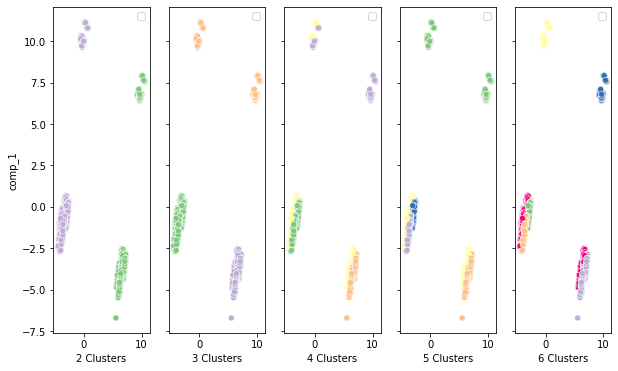

In [ ]:
df = table_orig_df.copy()

n_clusters_arr = np.arange(2, 7)
fig, ax = plt.subplots(nrows=len(percent_p_arr), ncols=len(n_clusters_arr), figsize=(10, 6), sharex=True, sharey=True)
for i, n_clusters in tqdm(enumerate(n_clusters_arr), total=len(n_clusters_arr), leave=False):
    temp_df = df.copy()
    temp_df.dropna(subset=['percent_positive'], inplace=True)
    clusters_df = create_cluster_proj_df(temp_df.values, n_clusters=n_clusters, scaled=True)  
    sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', ax=ax[i], palette='Accent')
    ax[i].set_xlabel(f'{n_clusters} Clusters')
    ax[i].legend([])

The clusters are still about the same, just orienting to the right. But again, we see that 3 clusters have the clearest cluster split

### Picking right number of clusters with inertia
Even though it's evident from the previous figure that 3 clusters is optimal for 40% percent_positive imputing, let's sanity check it with inertia plot over n_clusters

1 clusters: inertia=2375492.055025695
2 clusters: inertia=1595800.193821706
3 clusters: inertia=1124667.6159949917
4 clusters: inertia=873497.696922828
5 clusters: inertia=710654.4851858029
6 clusters: inertia=601591.7038594043
7 clusters: inertia=502908.4391771703
8 clusters: inertia=409836.9492886218
9 clusters: inertia=342896.1769877831


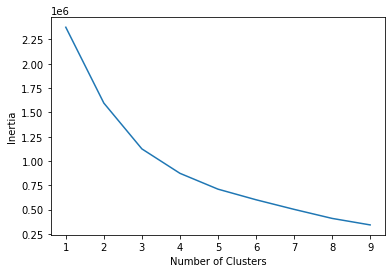

In [ ]:
df = table_orig_df.copy()
df['percent_positive'].fillna(0.4, inplace=True)
visualize_inertia(df.values, from_=1, to_=10)

There also doesn't seem to be clear intrinsic dimensions, so we'll go with 3 clusters based on this plot and our previous visualization on K-Mean clusters

### Checking cluster consistency
Due to the random initialization of K-Means algorithm, we want to make sure that the clusters are consistent across runs

  0%|          | 0/3 [00:00<?, ?it/s]

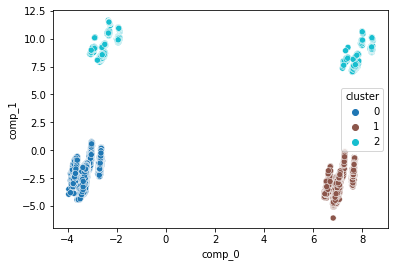

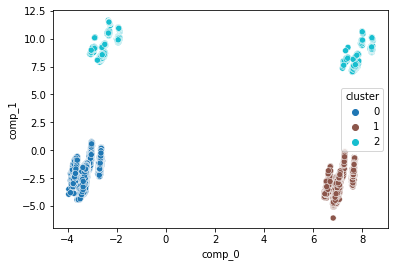

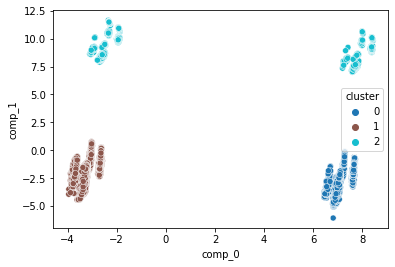

In [ ]:
num_repeats = 3
n_clusters = 3
for i in tqdm(range(num_repeats)):
    clusters_df = create_cluster_proj_df(df.values, n_clusters=n_clusters, scaled=True)  
    plt.figure()
    sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', palette=sns.color_palette('tab10', as_cmap=True))

The clusters are consistent across different initializations

### Cluster Results
Now we've decided to use 3 clusters, let's look at the means of the clusters derived from our model

0.0    23034
1.0     8426
2.0     4794
Name: cluster, dtype: int64


,achievements,original_price,percent_positive,num_reviews,multiplayer,mature,free,release_date_numeric,comp_0,comp_1,count
cluster,,,,,,,,,,,
0.0,31.014517,44.866778,0.589335,561.943240,0.264686,0.075873,0.116617,12888.307462,-2.935664,-1.296085,20666
1.0,24.921803,13.276269,0.578456,1193.925483,0.276778,0.072414,0.119989,12921.862137,7.465282,-2.096592,7609
2.0,24.378066,12.567861,0.550245,397.754953,0.262972,0.068632,0.121226,12915.685142,0.984068,9.912370,4240


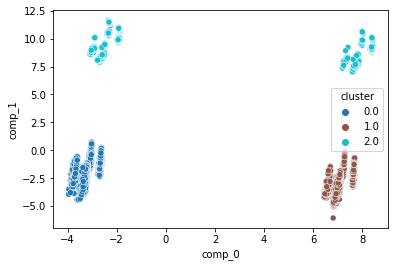

In [ ]:
clusters_df = create_cluster_proj_df(df.values, n_clusters=3, scaled=True)
clusters_df = pd.concat([df, clusters_df], axis=1)  
sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', palette=sns.color_palette('tab10', as_cmap=True))
print(clusters_df['cluster'].value_counts())
clusters_mean_df = clusters_df.groupby('cluster').mean()
clusters_mean_df['count'] = clusters_df.groupby('cluster').count().iloc[:, 0].rename('count')
clusters_mean_df.head()

Two categories stand out is that cluster 0 has significantly the highest original_price and achivements, while cluster 1 has the most num_reviews. Therefore, the takeaway from this is that `num_reviews`, `original_price`, and `achievements` seem to have clear cluster structure. However, the other features `multiplayer`, `mature`, `release_date`, seem to be pretty similar across clusters. This shows that our K-Mean algorithm suffers from high feature dimension, also known as curse of dimensionality as the algorithm is distance based. 

In addition, a more advanced projection algorithm like t-SNE or UMAP should be able to distinguish the two clusters on the top as they retain the proximity of the original features much better than PCA. An analysis either by downsampling the data or getting better compute will be one of the future directions of this analysis

### Constrained Feature Space
As mentioned before, our K-Mean algorithm suffers from high feature dimension, also known as curse of dimensionality as the algorithm is distance based. Therefore we'll perform our analysis below with some reduced features

We'll look at the 3 features that we see have clear structures ['achievements', 'num_reviews', 'original_price'], and try to cluster them

,achievements,num_reviews,original_price,comp_0,comp_1,count
cluster,,,,,,
0.0,32.763256,1879.437669,14.746261,5.332418,0.716996,7789
1.0,23.759827,118.487424,12.510695,-3.522689,0.474660,14552
2.0,34.629328,771.850324,103.392847,0.725410,-3.615237,7249
3.0,28.022222,145.595556,12.005022,0.754981,4.811987,2925


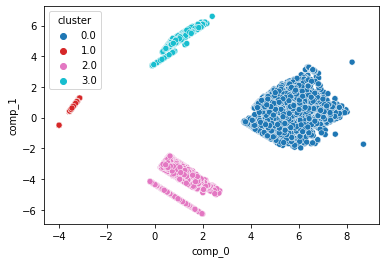

In [ ]:
np.random.seed(10)
df = table_orig_df.copy()
df['percent_positive'].fillna(0, inplace=True)
df = df[['achievements', 'num_reviews', 'original_price']]

plt.figure()
clusters_df = create_cluster_proj_df(df.values, n_clusters=4, scaled=True)
clusters_df = pd.concat([df, clusters_df], axis=1)  
sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', palette=sns.color_palette('tab10', as_cmap=True))
clusters_mean_df = clusters_df.groupby('cluster').mean()
clusters_mean_df['count'] = clusters_df.groupby('cluster').count().iloc[:, 0].rename('count')
clusters_mean_df.head()

We see cluster 0 and 1 both have high achivements and high number of reviews. Therefore, it encourages to have a new category **popular and fulfilling**. 

,release_date_numeric,percent_positive,num_reviews,comp_0,comp_1,count
cluster,,,,,,
0.0,12746.569938,0.550107,1397.905891,4.455630,0.041658,14377
1.0,13026.706690,0.258767,122.961635,-4.076048,0.007134,17490
2.0,12870.648148,0.433009,209.702160,7.181353,-1.155489,648


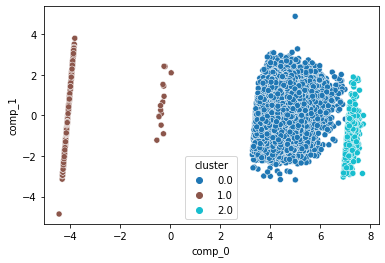

In [ ]:
np.random.seed(10)
df = table_orig_df.copy()
df['percent_positive'].fillna(0, inplace=True)
df = df[['release_date_numeric', 'percent_positive', 'num_reviews']]

clusters_df = create_cluster_proj_df(df.values, n_clusters=3, scaled=True)
clusters_df = pd.concat([df, clusters_df], axis=1)  
sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', palette=sns.color_palette('tab10', as_cmap=True))
clusters_mean_df = clusters_df.groupby('cluster').mean()
clusters_mean_df['count'] = clusters_df.groupby('cluster').count().iloc[:, 0].rename('count')
clusters_mean_df.head()

We see cluster 0 is consistently one of the largest and well-defined cluster. In this cluster we see that it has higher `percent_positive`, higher `num_reviews`. This shows that we can have categories such as **most popular**, **most liked**, or **popular and liked**

,free,release_date_numeric,num_reviews,comp_0,comp_1,count
cluster,,,,,,
0.0,0.111188,12750.494494,1436.875491,-1.141320,3.281561,12987
1.0,0.122907,13022.078689,133.241497,-1.580759,-2.748038,15288
2.0,0.114578,12764.041443,767.128718,9.238475,2.639032,2051
3.0,0.127455,13057.768844,51.667428,8.811385,-3.578589,2189


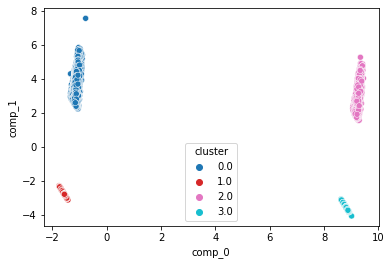

In [ ]:
np.random.seed(10)
df = table_orig_df.copy()
df['percent_positive'].fillna(0, inplace=True)
df = df[['free', 'release_date_numeric', 'num_reviews']]

plt.figure()
clusters_df = create_cluster_proj_df(df.values, n_clusters=4, scaled=True)
clusters_df = pd.concat([df, clusters_df], axis=1)  
sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', palette=sns.color_palette('tab10', as_cmap=True))
clusters_mean_df = clusters_df.groupby('cluster').mean()
clusters_mean_df['count'] = clusters_df.groupby('cluster').count().iloc[:, 0].rename('count')
clusters_mean_df.head()

,free,release_date_numeric,percent_positive,comp_0,comp_1,count
cluster,,,,,,
0.0,0.110974,12750.108662,0.551592,-1.218569,3.344892,12976
1.0,0.123080,13022.210667,0.272280,-1.513969,-2.839421,15299
2.0,0.127796,13058.100867,0.164409,8.895607,-3.405152,2191
3.0,0.114202,12763.399707,0.503670,9.163476,2.753085,2049


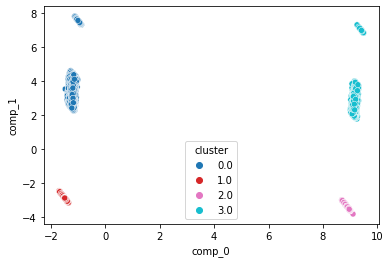

In [ ]:
np.random.seed(10)
df = table_orig_df.copy()
df['percent_positive'].fillna(0, inplace=True)
df = df[['free', 'release_date_numeric', 'percent_positive']]

plt.figure()
clusters_df = create_cluster_proj_df(df.values, n_clusters=4, scaled=True)
clusters_df = pd.concat([df, clusters_df], axis=1)  
sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', palette=sns.color_palette('tab10', as_cmap=True))
clusters_mean_df = clusters_df.groupby('cluster').mean()
clusters_mean_df['count'] = clusters_df.groupby('cluster').count().iloc[:, 0].rename('count')
clusters_mean_df.head()

We see that constrained the feature space with ['free', 'release_date_numeric', 'num_reviews'] shows that the two latest and least free clusters have highest `num_reviews`, encouraging us to have new categories like paid premium

We see that constrained the feature space with ['free', 'release_date_numeric', 'percent_positive'] shows that the two latest and least free clusters have highest `percent_positive`, encouraging us to have new categories like **paid premium**

We arrive at the same conclusion using either `num_review` or `percent_positive` as our metric

,release_date_numeric,mature,multiplayer,comp_0,comp_1,count
cluster,,,,,,
0.0,12900.697116,0.073941,0.262377,-2.794438,-0.877751,21774
1.0,12906.718474,0.072467,0.274970,7.596545,-0.463616,8390
2.0,12848.065705,0.078526,0.283120,-3.216448,9.533813,1872
3.0,12935.260960,0.093946,0.294363,7.173558,9.953589,479


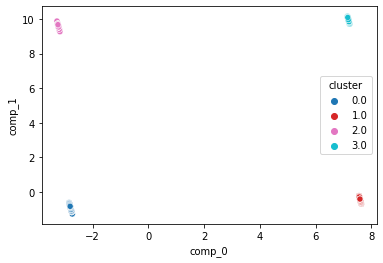

In [ ]:
np.random.seed(10)
df = table_orig_df.copy()
df['percent_positive'].fillna(0, inplace=True)
df = df[['release_date_numeric', 'mature', 'multiplayer']]

plt.figure()
clusters_df = create_cluster_proj_df(df.values, n_clusters=4, scaled=True)
clusters_df = pd.concat([df, clusters_df], axis=1)  
sns.scatterplot(x='comp_0', y='comp_1', data=clusters_df, hue='cluster', palette=sns.color_palette('tab10', as_cmap=True))
clusters_mean_df = clusters_df.groupby('cluster').mean()
clusters_mean_df['count'] = clusters_df.groupby('cluster').count().iloc[:, 0].rename('count')
clusters_mean_df.head()

We echo our earlier analysis that there seems not to be a specific cluster that uses `release_date`, `mature`, or `multiplayer`. Therefore, it shouldn't be our priority to use this three categories on our platform